In [1]:
ord("И") % 5

3

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_gaussian_quantiles
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
import pandas as pd
import numpy as np

## Формирование искусственного набора данных

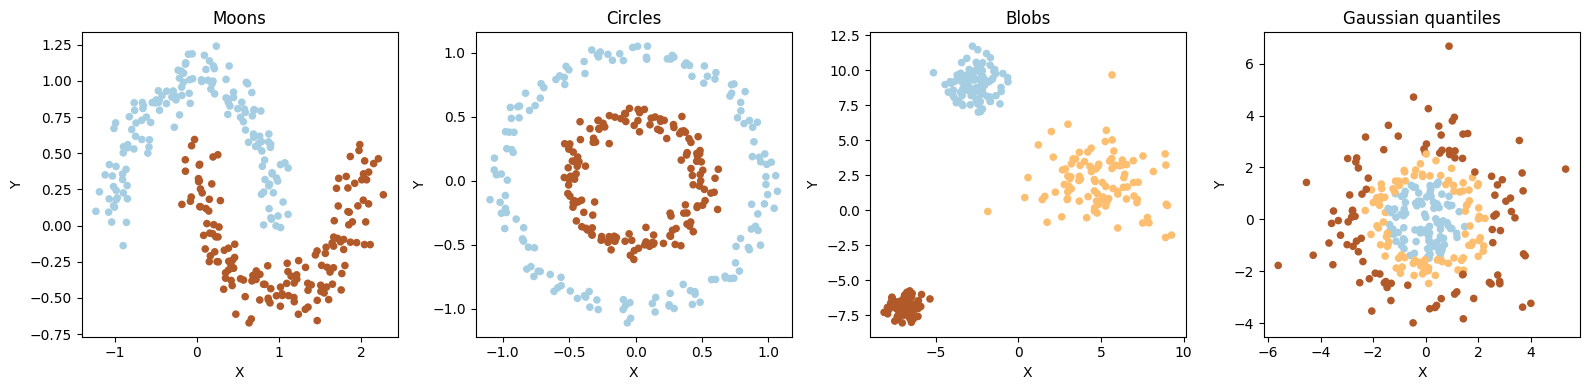

In [69]:
# Полумесяцы
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

# Концентрические круги
X_circles, y_circles = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

# Кластеры
X_blobs, y_blobs = make_blobs(n_samples=300, centers=3, cluster_std=[1.0, 2.0, 0.5], random_state=42)

# Концентрические слои
X_GQ, y_GQ = make_gaussian_quantiles(n_samples=300, mean=(0, 0), cov=3.0, n_features=2, n_classes=3, random_state=42)

datasets = [(X_moons, y_moons, "Moons"), 
            (X_circles, y_circles, "Circles"),
            (X_blobs, y_blobs, "Blobs"), 
            (X_GQ, y_GQ, "Gaussian quantiles")]

# Визуализация
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, (X, y, title) in zip(axes, datasets):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.tight_layout()
plt.show()


## Сравнительный анализ алгоритмов кластеризации

Оценки методов кластеризации:
- **Entropy** - оценка энтропии кластерного решения (неоднородности кластеров по классам). Чем меньше энтропия, тем лучше качество кластеризации.
$$ E(K) = -\sum_{k=1}^{K}\frac{n_k}{N} \sum_{c=1}^{C}\frac{n_{kc}}{n_k} log_2 \frac{n_{kc}}{n_k} $$

$K$ - количество кластеров,<br>
$C$ - количество истинных классов,<br>
$n_k$ - количество объектов в кластере $k$,<br>
$n_{kc}$ - количество объектов истинного класса $c$ в кластере $k$,<br>
$N$ - общее количество объектов.

- **Homogeneity Score** (однородность) — это метрика, используемая для оценки качества кластеризации. Она показывает, насколько каждый кластер содержит только элементы одного класса.
$$ Homogeneity = 1 - \frac{H(C|K)}{H(C)} $$
$H(C|K)$ - условная энтропия классов $C$ относительно кластеров $K$,<br>
$H(C)$ - энтропия классов $C$.

- **ARI (Adjusted Rand Index)** ARI - оценка совпадений классов и кластеров.
$$ ARI = \frac{RI - E[RI]}{max(RI) - E[RI]}$$
$RI$ — индекс Рэнда, показывающий долю согласованных пар (обе точки в одном кластере или в разных)<br>
$E[RI]$ — ожидаемая вероятность совпадения при случайной кластеризации.

- **Silhouette Score** оценивает, насколько хорошо каждый объект относится к своему кластеру, и насколько он далек от объектов других кластеров (по внутренним критериям)
$$ sw = \frac{1}{n} \sum_{i=1}^{n} sw_i, \quad sw_i = \frac{b_i - a_i}{max(a_i;b_i)} $$
$a_i$ - среднее расстояние относительно от всех других точек в своем кластере, <br>
$b_i$ - минимальное из средних расстояний относительно всех других точек в каждом кластере.


Функция для подсчета энтропии кластеризации

In [110]:
def calculate_entropy(y_true, y_pred, n_clusters):
    """Рассчитывает энтропию кластерного решения."""
    entropy = 0
    for k in range(n_clusters):
        cluster_indices = np.where(y_pred == k)[0]
        cluster_classes, counts = np.unique(y_true[cluster_indices], return_counts=True)
        cluster_size = len(cluster_indices)
        if cluster_size > 0:
            cluster_entropy = -np.sum((counts / cluster_size) * np.log2(counts / cluster_size))
            entropy += (cluster_size / len(y_true)) * cluster_entropy
    return entropy

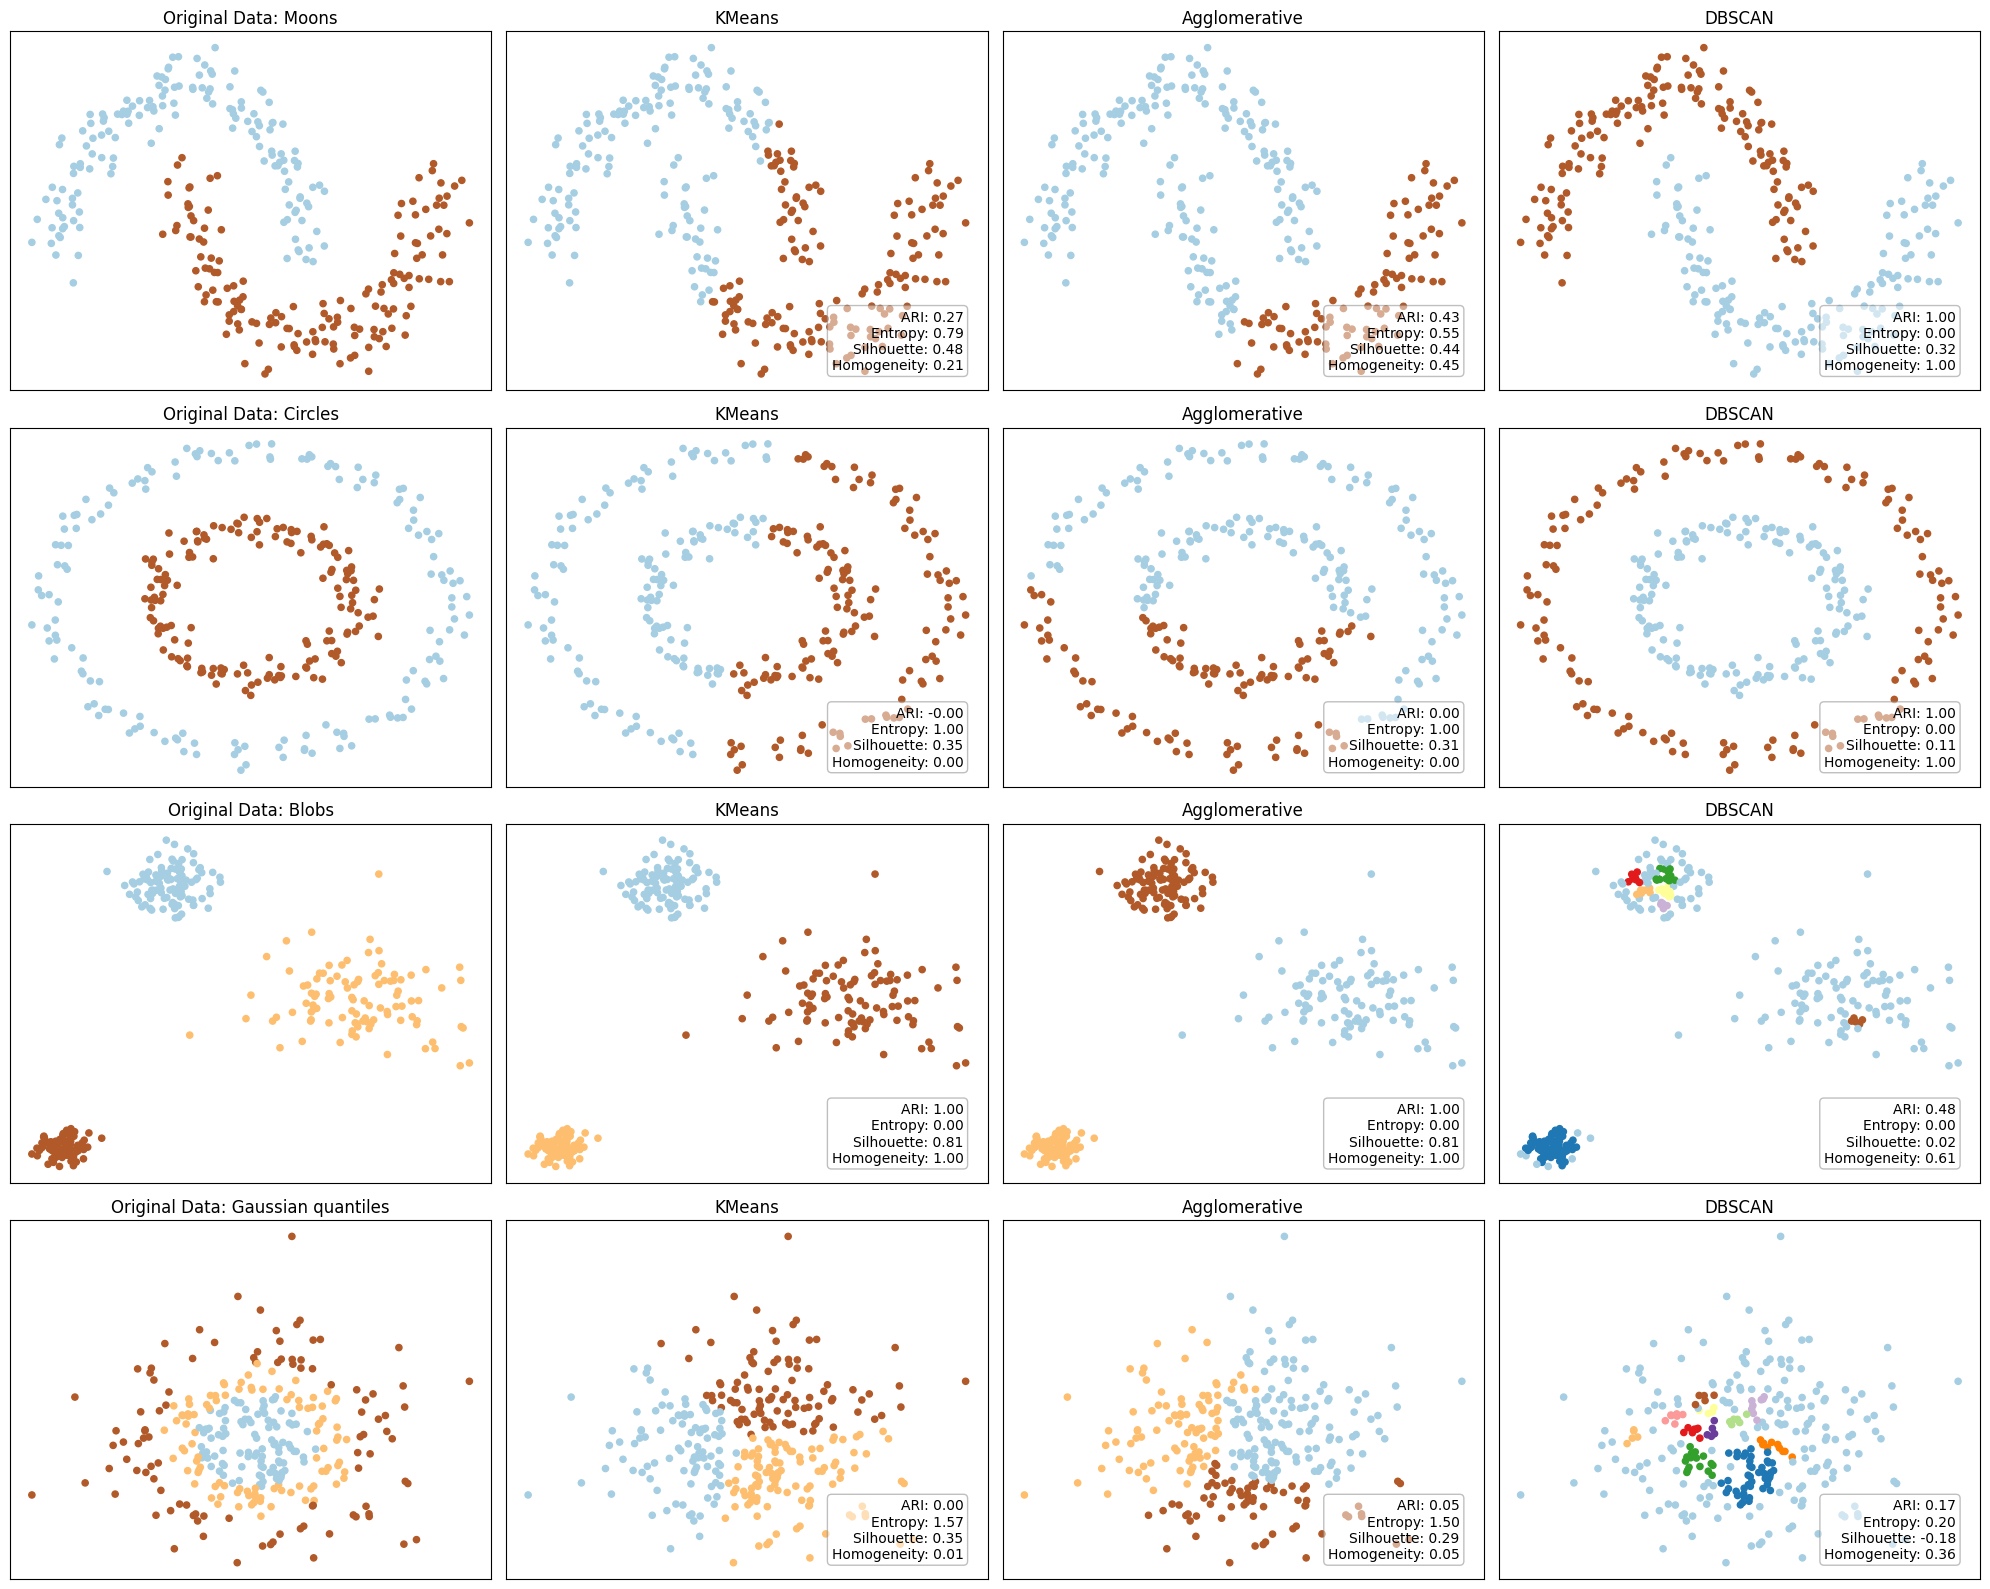

In [112]:
# Параметры кластеризации
cluster_algorithms_for_datasets = [
    [
        ("KMeans", KMeans(n_clusters=2, random_state=42)),
        ("Agglomerative", AgglomerativeClustering(n_clusters=2)),
        ("DBSCAN", DBSCAN(eps=0.2)),
    ],
    [
        ("KMeans", KMeans(n_clusters=2, random_state=42)),
        ("Agglomerative", AgglomerativeClustering(n_clusters=2)),
        ("DBSCAN", DBSCAN(eps=0.2)),
    ],
    [
        ("KMeans", KMeans(n_clusters=3, random_state=42)),
        ("Agglomerative", AgglomerativeClustering(n_clusters=3)),
        ("DBSCAN", DBSCAN(eps=0.3)),
    ],
    [
        ("KMeans", KMeans(n_clusters=3, random_state=42)),
        ("Agglomerative", AgglomerativeClustering(n_clusters=3)),
        ("DBSCAN", DBSCAN(eps=0.3)),
    ],
]

# Визуализация
def show_datasets_plots_by_cluster_algorithm(cluster_algorithms):
    """Выводит графики и оценки для заданных методов кластеризации."""
    fig, axes = plt.subplots(len(datasets), 4, figsize=(20, 16))

    for i, (X, y_true, title) in enumerate(datasets):
        # Исходные данные
        axes[i, 0].scatter(X[:, 0], X[:, 1], c=y_true, cmap=plt.cm.Paired, s=20)
        axes[i, 0].set_title(f"Original Data: {title}")
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])

        # Кластеризация
        for j, (name, algorithm) in enumerate(cluster_algorithms_for_datasets[i]):
            y_pred = algorithm.fit_predict(X)
            axes[i, j + 1].scatter(X[:, 0], X[:, 1], c=y_pred, cmap=plt.cm.Paired, s=20)
            axes[i, j + 1].set_title(name)
            axes[i, j + 1].set_xticks([])
            axes[i, j + 1].set_yticks([])

            # Вычисление оценок
            ari = adjusted_rand_score(y_true, y_pred)
            n_clusters = len(np.unique(y_pred))
            entropy = calculate_entropy(y_true, y_pred, n_clusters)  # Энтропия
            silhouette = silhouette_score(X, y_pred) if len(set(y_pred)) > 1 else -1
            homogeneity = homogeneity_score(y_true, y_pred)

            # Вывод метрик на графике
            metrics_text = (
                f"ARI: {ari:.2f}\n"
                f"Entropy: {entropy:.2f}\n"
                f"Silhouette: {silhouette:.2f}\n"
                f"Homogeneity: {homogeneity:.2f}"
            )
            axes[i, j + 1].text(
                0.95, 
                0.05, 
                metrics_text, 
                transform=axes[i, j + 1].transAxes, 
                fontsize=10, 
                va='bottom', 
                ha='right', 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.5)
            )

    plt.tight_layout()
    plt.show()

show_datasets_plots_by_cluster_algorithm(cluster_algorithms_for_datasets)


**KMeans** - неиерархический метод кластеризации с фиксированным числом кластеров. Алгоритм итеративно распределяет точки по кластерам и
смещает центры кластеров. Проблемы алгоритма: обоснованность выбора числа k, начальных центров кластеров, аномальные выбросы 

**Agglomerative** - иеарархические агломеративные методы кластеризации. Начинается с того, что каждый объект является отдельным кластером, а затем постепенно наиболее близкие кластеры объединяются в более крупные. (single-link, complete-link, etc.) По умолчанию 'ward': минимизирует дисперсию объединяемых кластеров.

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) - это метод кластеризации, основанный на плотности данных. Он определяет кластеры как области с высокой плотностью объектов, разделённые областями с низкой плотностью. (его иерархическая версия - HDBSCAN)

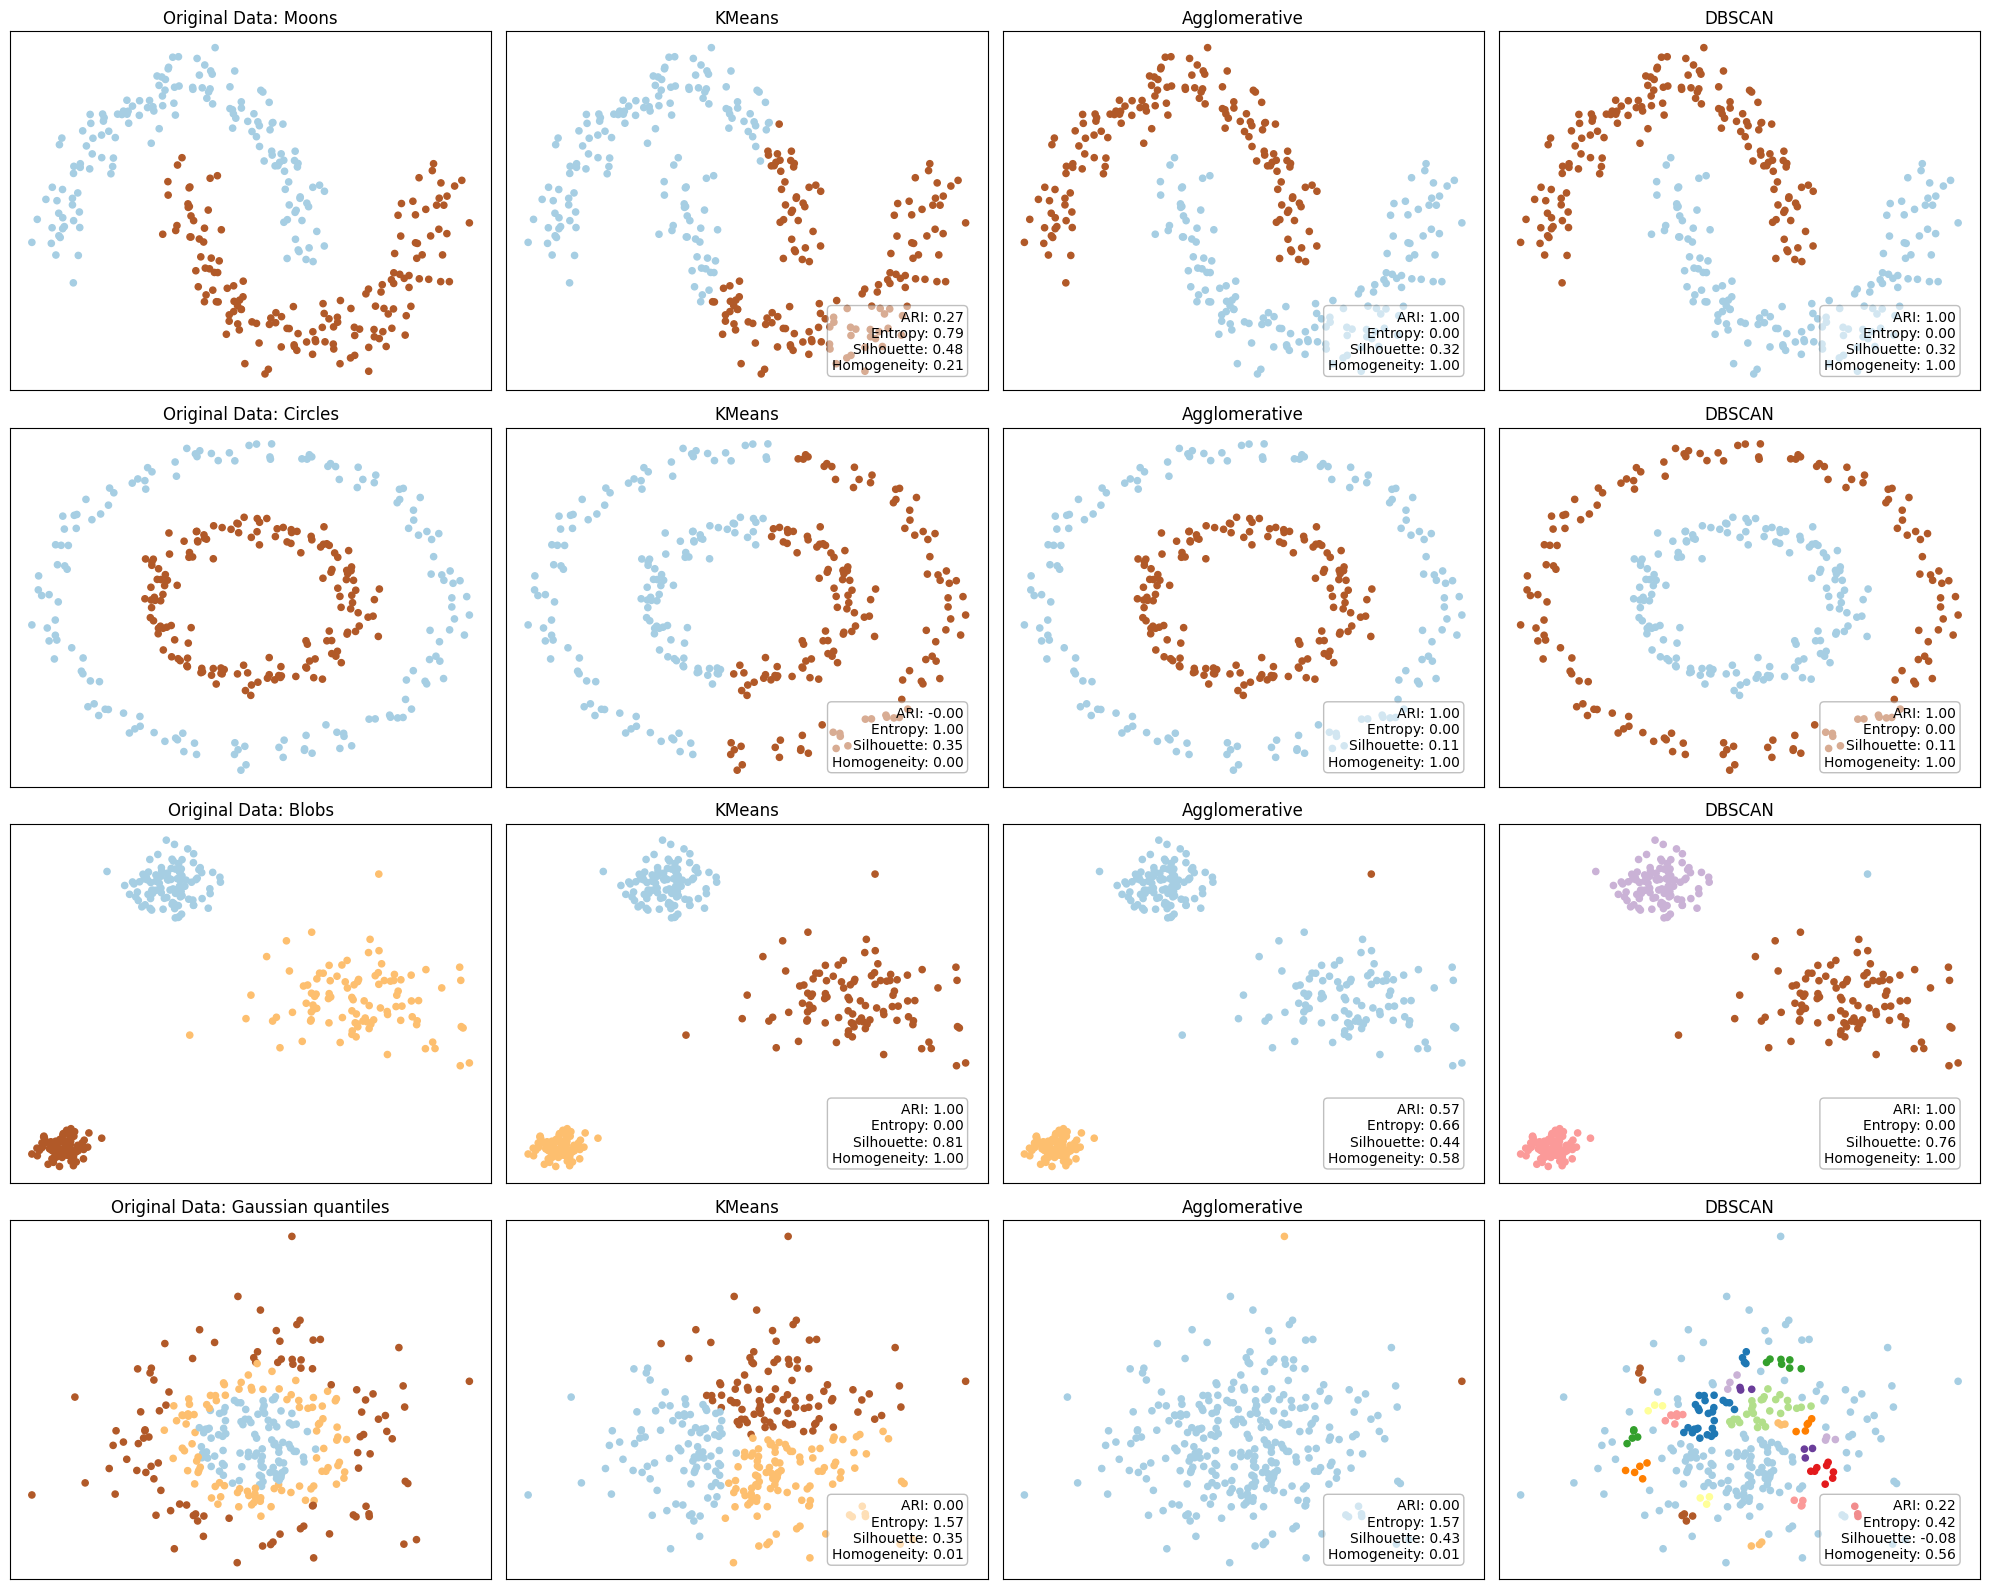

In [117]:
# Обновленные параметры кластеризации для соответствия количеству классов
cluster_algorithms_for_datasets = [
    [
        ("KMeans", KMeans(n_clusters=2, random_state=42)),
        ("Agglomerative", AgglomerativeClustering(n_clusters=2, linkage='single')),
        ("DBSCAN", DBSCAN(eps=0.2, min_samples=5)),
    ],
    [
        ("KMeans", KMeans(n_clusters=2, random_state=42)),
        ("Agglomerative", AgglomerativeClustering(n_clusters=2, linkage='single')),
        ("DBSCAN", DBSCAN(eps=0.2, min_samples=5)),
    ],
    [
        ("KMeans", KMeans(n_clusters=3, random_state=42)),
        ("Agglomerative", AgglomerativeClustering(n_clusters=3, linkage='single')),
        ("DBSCAN", DBSCAN(eps=3, min_samples=3)),
    ],
    [
        ("KMeans", KMeans(n_clusters=3, random_state=42)),
        ("Agglomerative", AgglomerativeClustering(n_clusters=3, linkage='single')),
        ("DBSCAN", DBSCAN(eps=0.3, min_samples=3)),
    ],
]

show_datasets_plots_by_cluster_algorithm(cluster_algorithms_for_datasets)


## Набор с многомерными данными

Ozone Level Detection - эти данные были собраны с 1998 по 2004 год в районах Хьюстона, Галвестона и Бразории.

Источник: https://www.kaggle.com/datasets/prashant111/ozone-level-detection

In [2]:
df = pd.read_csv('eighthr.data.csv', header=None)
# print(df.info())
df

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
4,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,?,?,?,?,?,?,?,?,0.58,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2529,12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,...,0.07,7.93,-4.41,5800,-25.6,21.8,10295,65,0,0.0
2530,12/28/2004,1,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,...,0.04,5.95,-1.14,5845,-19.4,19.1,10310,15,0,0.0
2531,12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,...,0.06,7.8,-0.64,5845,-9.6,35.2,10275,-35,0,0.0
2532,12/30/2004,1.3,0.9,1.5,1.2,1.6,1.8,1.1,1,1.9,...,0.25,7.72,-0.89,5845,-19.6,34.2,10245,-30,0.05,0.0


In [ ]:
df.shape

(2534, 74)

### Устранение пропусков

In [3]:
for i in df.columns:
    df[i]=df[i].replace(["?"],np.nan)

df.isna().sum()

0       0
1     299
2     292
3     294
4     292
     ... 
69    125
70     95
71    158
72      2
73      0
Length: 74, dtype: int64

In [4]:
# приведение данных к типу float кроме последнего столбца
for i in df.columns[1:-1]:
    df[i]=df[i].astype(float)

for i in df.columns:
    if df[i].isnull().sum()>0:
        df[i] = df[i].ffill()
df

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,1/1/1998,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795.0,-12.10,17.90,10330.0,-55.0,0.00,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805.0,14.05,29.00,10275.0,-55.0,0.00,0.0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.60,6.94,9.80,5790.0,17.90,41.30,10235.0,-40.0,0.00,0.0
3,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775.0,31.15,51.70,10195.0,-40.0,2.08,0.0
4,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,0.49,8.73,10.54,5775.0,31.15,51.70,10195.0,-40.0,0.58,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2529,12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,...,0.07,7.93,-4.41,5800.0,-25.60,21.80,10295.0,65.0,0.00,0.0
2530,12/28/2004,1.0,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,...,0.04,5.95,-1.14,5845.0,-19.40,19.10,10310.0,15.0,0.00,0.0
2531,12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,...,0.06,7.80,-0.64,5845.0,-9.60,35.20,10275.0,-35.0,0.00,0.0
2532,12/30/2004,1.3,0.9,1.5,1.2,1.6,1.8,1.1,1.0,1.9,...,0.25,7.72,-0.89,5845.0,-19.60,34.20,10245.0,-30.0,0.05,0.0


In [142]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,...,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000
mean,1.716338,1.675493,1.587017,1.509234,1.484925,1.503710,1.623639,2.105130,2.581807,2.928571,...,0.305675,10.098560,0.990091,5819.652723,10.657202,37.428848,10164.293607,-0.134175,0.375691,0.063141
std,1.243329,1.240033,1.188603,1.151433,1.157878,1.133881,1.131722,1.118561,1.125653,1.186999,...,0.249480,9.609166,7.453919,78.971614,20.727389,11.240708,52.476512,35.304800,1.323917,0.243265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,...,0.010000,-14.920000,-25.990000,5480.000000,-56.700000,-10.100000,9975.000000,-135.000000,0.000000,0.000000
25%,0.700000,0.600000,0.600000,0.700000,0.600000,0.700000,0.800000,1.300000,1.800000,2.100000,...,0.090000,2.600000,-3.587500,5770.000000,-3.450000,32.400000,10130.000000,-20.000000,0.000000,0.000000
50%,1.500000,1.400000,1.400000,1.200000,1.100000,1.200000,1.300000,2.100000,2.600000,2.900000,...,0.230000,9.435000,0.500000,5835.000000,15.200000,41.200000,10160.000000,0.000000,0.000000,0.000000
75%,2.400000,2.600000,2.100000,2.100000,2.100000,2.100000,2.100000,2.700000,3.200000,3.800000,...,0.470000,17.012500,5.160000,5880.000000,28.437500,45.200000,10195.000000,15.000000,0.050000,0.000000
max,7.500000,7.700000,7.100000,7.300000,7.200000,7.400000,7.400000,7.500000,9.200000,8.500000,...,1.000000,42.360000,30.420000,5965.000000,42.050000,59.150000,10350.000000,140.000000,20.650000,1.000000


### Подготовка данных

In [287]:
df[73].value_counts()   # наличие осадков

73
0.0    2374
1.0     160
Name: count, dtype: int64

In [5]:
X = df.drop([0, 73], axis=1)
y = df[73]

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Кластеризация данных

#### KMeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)  # 2 кластера
y_kmeans = kmeans.fit_predict(X)
y_kmeans_scaled = kmeans.fit_predict(X_scaled)

# Оценки
print("No scale X:")
print("Silhouette Score:", silhouette_score(X, y_kmeans))

print("\nScaled X:")
print("Silhouette Score:", silhouette_score(X_scaled, y_kmeans_scaled))

No scale X:
Silhouette Score: 0.39054085920343434

Scaled X:
Silhouette Score: 0.2934571531603675


#### DBSCAN

In [9]:
dbscan = DBSCAN(eps=10, min_samples=5)
y_dbscan = dbscan.fit_predict(X)
y_dbscan_scaled = dbscan.fit_predict(X_scaled)

# Оценки
print("No scale X:")
print("Silhouette Score:", silhouette_score(X, y_dbscan))

print("Scaled X:")
print("Silhouette Score:", silhouette_score(X_scaled, y_dbscan_scaled))

No scale X:
Silhouette Score: -0.12027794125424815
Scaled X:
Silhouette Score: 0.48075703112766155


#### Agglomerative Clustering

In [249]:
agg_clustering = AgglomerativeClustering(n_clusters=2, metric='manhattan', linkage='single')
y_agg_scaled = agg_clustering.fit_predict(X_scaled)
y_agg = agg_clustering.fit_predict(X)

# Оценки
print("No scale X:")
print("Silhouette Score:", silhouette_score(X, y_agg))

print("Scaled X:")
print("Silhouette Score:", silhouette_score(X_scaled, y_agg_scaled))

No scale X:
Silhouette Score: 0.5916862799328554
Scaled X:
Silhouette Score: 0.5097977477151926


### Визуализация

In [239]:
def show_diagrams_of_clustering(X_pred, y_pred):
    silhouette_avg = silhouette_score(X_pred, y_pred)
    # Оценка для каждого объекта
    silhouette_values = silhouette_samples(X_pred, y_pred)

    df_clusters = pd.DataFrame({'Cluster': y_pred, 'Class': y})
    cluster_distribution = df_clusters.groupby(['Cluster', 'Class']).size().unstack(fill_value=0)

    print("\nРаспределение объектов по кластерам и классам:")
    print(cluster_distribution)

    # Построение графиков
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Диаграмма частот
    cluster_distribution.plot(kind='bar', stacked=True, ax=axes[0])
    axes[0].set_title("Распределение объектов по кластерам и классам")
    axes[0].set_xlabel("Кластер")
    axes[0].set_ylabel("Количество объектов")
    axes[0].legend(title="Класс")

    # Silhouette диаграмма
    y_lower = 10
    for i in range(2):
        cluster_silhouette_values = silhouette_values[y == i]
        cluster_silhouette_values.sort()
        y_upper = y_lower + cluster_silhouette_values.shape[0]

        axes[1].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouette_values,
            alpha=0.7,
            label=f"Кластер {i}",
        )
        y_lower = y_upper + 10

    axes[1].axvline(x=silhouette_avg, color="red", linestyle="--")
    axes[1].set_title("Silhouette диаграмма")
    axes[1].set_xlabel("Silhouette коэффициент")
    axes[1].set_ylabel("Объекты")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


Распределение объектов по кластерам и классам:
Class     0.0  1.0
Cluster           
0        1468  137
1         906   23


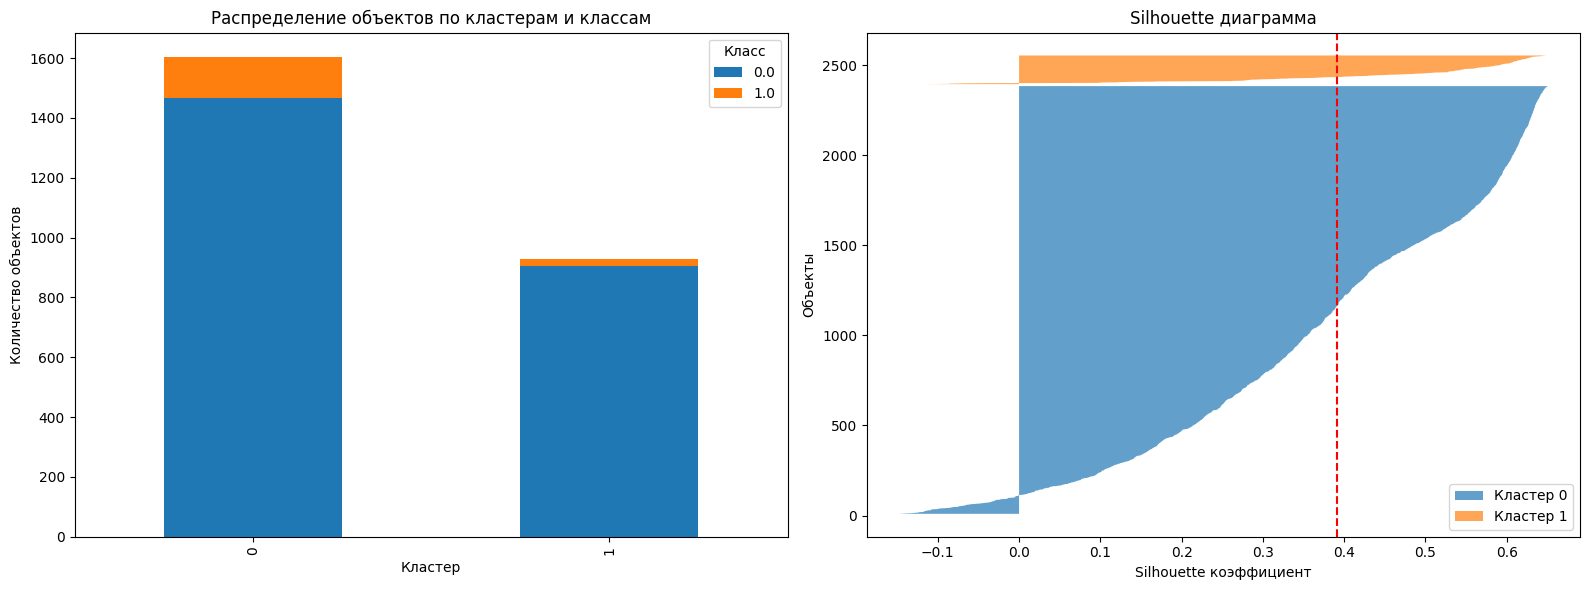

In [280]:
show_diagrams_of_clustering(X, y_kmeans)


Распределение объектов по кластерам и классам:
Class     0.0  1.0
Cluster           
-1          2    0
 0       2372  160


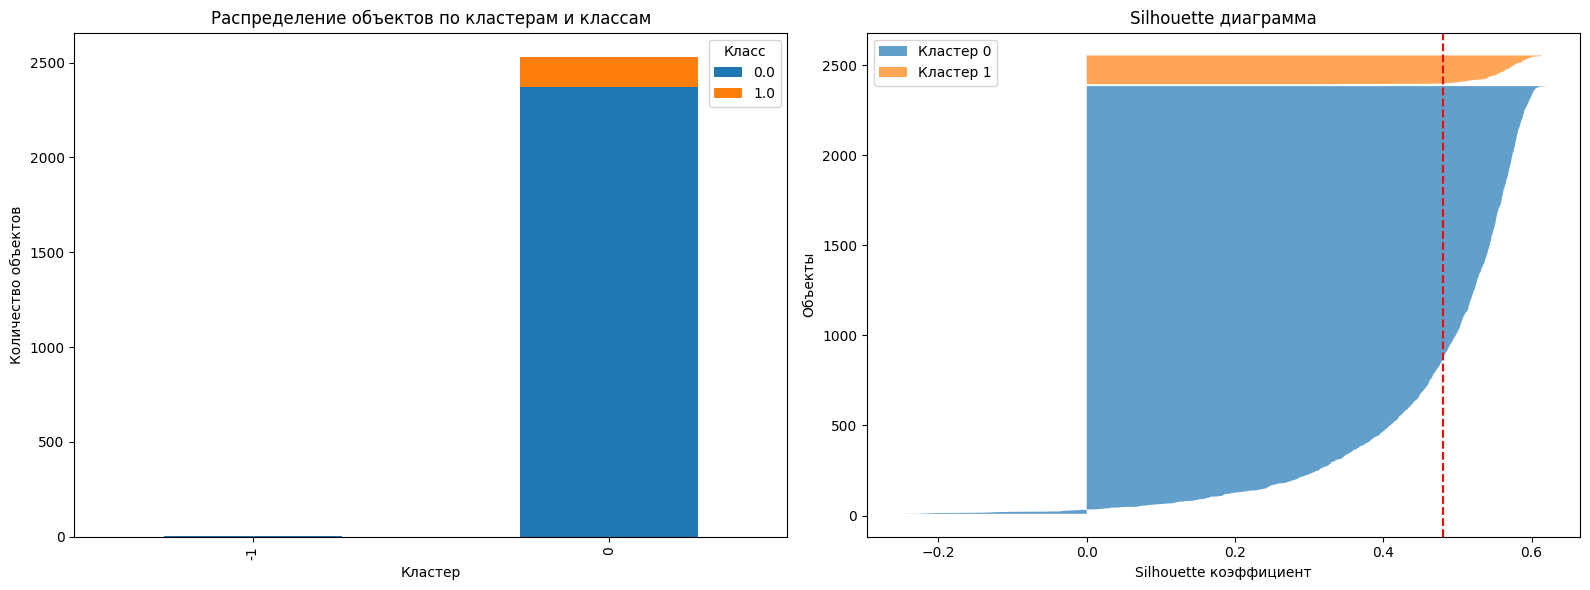

In [ ]:
show_diagrams_of_clustering(X_scaled, y_dbscan_scaled)


Распределение объектов по кластерам и классам:
Class     0.0  1.0
Cluster           
0        2371  160
1           3    0


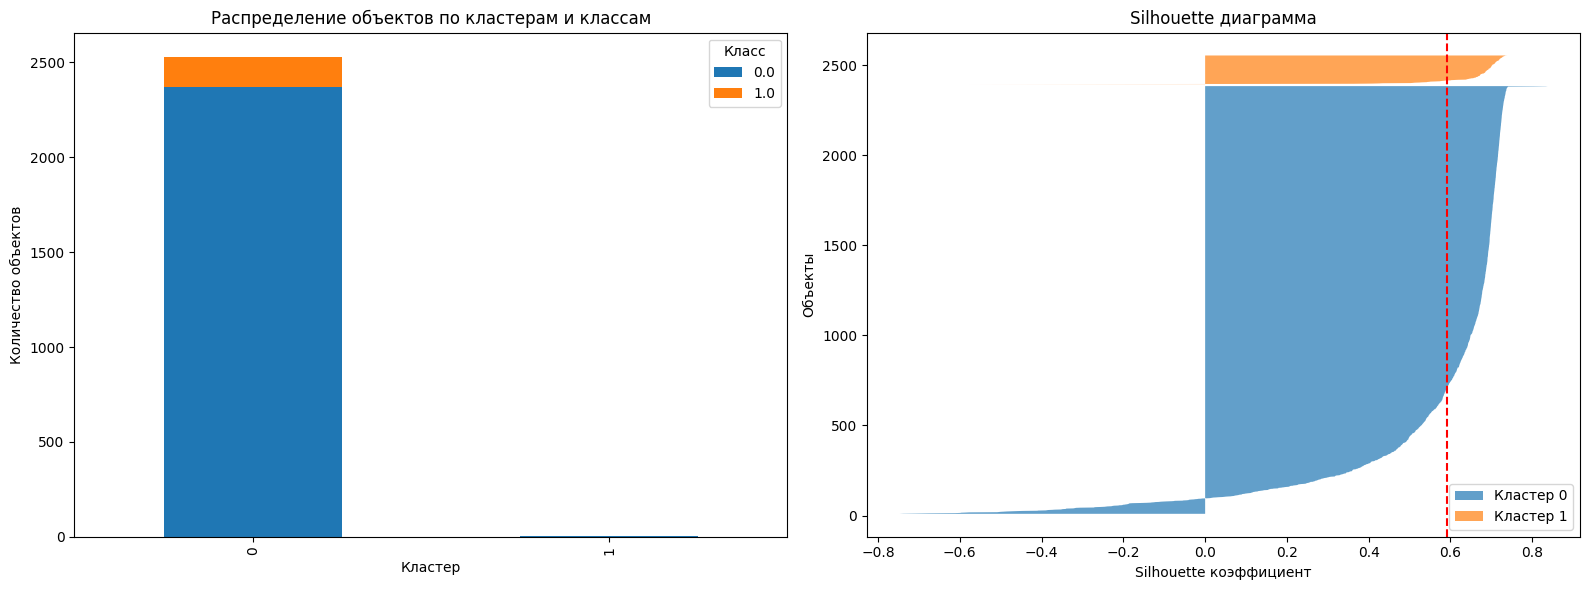

In [281]:
show_diagrams_of_clustering(X, y_agg)


Распределение объектов по кластерам и классам:
Class     0.0  1.0
Cluster           
0        2373  160
1           1    0


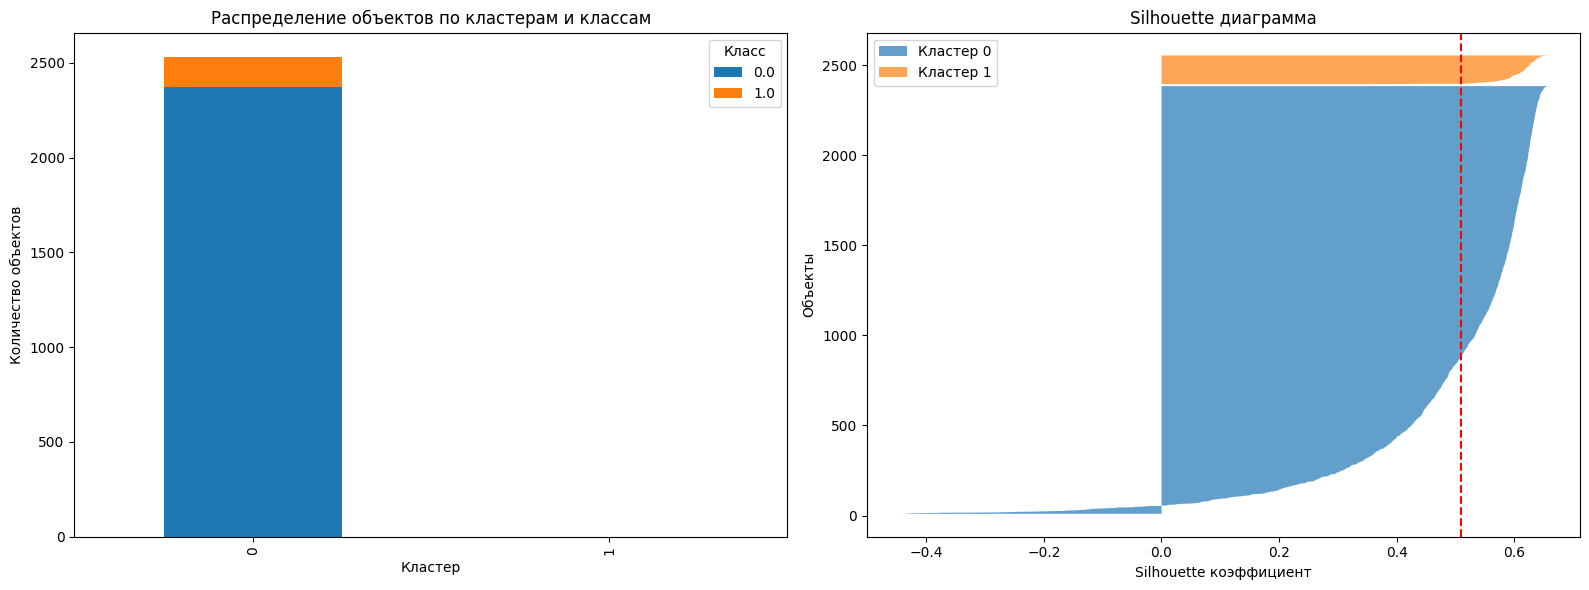

In [282]:
show_diagrams_of_clustering(X_scaled, y_agg_scaled)